In [7]:
import pandas as pd
print(pd.read_csv('/home/guilherme/Documentos/archive/symbols_valid_meta.csv').head())


  Nasdaq Traded Symbol                                      Security Name  \
0             Y      A            Agilent Technologies, Inc. Common Stock   
1             Y     AA                    Alcoa Corporation Common Stock    
2             Y   AAAU                       Perth Mint Physical Gold ETF   
3             Y   AACG  ATA Creativity Global - American Depositary Sh...   
4             Y   AADR                AdvisorShares Dorsey Wright ADR ETF   

  Listing Exchange Market Category ETF  Round Lot Size Test Issue  \
0                N                   N           100.0          N   
1                N                   N           100.0          N   
2                P                   Y           100.0          N   
3                Q               G   N           100.0          N   
4                P                   Y           100.0          N   

  Financial Status CQS Symbol NASDAQ Symbol NextShares  
0              NaN          A             A          N  
1       

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os tickers da coluna 'symbol'
tickers = pd.read_csv('/home/guilherme/Documentos/archive/symbols_valid_meta.csv')['Symbol'].unique()

# Criar DataFrame para dividendos e lista de erros
dividend_data = pd.DataFrame()
errors = []

# Buscar dados de dividendos
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Verificar se temos as informações necessárias
        if 'dividendYield' in info and info['dividendYield'] is not None:
            data = {
                'Ticker': ticker,
                'Dividend_Yield': info['dividendYield'],
                'Annual_Dividend_Rate': info.get('trailingAnnualDividendRate', 0),
                'Market_Price': info.get('regularMarketPrice', 0)
            }
            dividend_data = pd.concat([dividend_data, pd.DataFrame([data])], ignore_index=True)
        else:
            errors.append(f"{ticker}: sem dados de dividend yield")
            
    except Exception as e:
        errors.append(f"Erro em {ticker}: {str(e)}")

# Verificar quantidade de ações processadas e erros
print(f"Total de ações processadas: {len(dividend_data)}")
print(f"Total de erros: {len(errors)}")


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAU?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AAU&crumb=E1gsA6.0OEu
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=E1gsA6.0OEu
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABMD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABMD&crumb=E1gsA6.0OEu
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACRX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.co

Total de ações processadas: 2188
Total de erros: 5861


/tmp/ipykernel_156611/2122219259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dividend_data_clean['target'] = np.where(dividend_data_clean['Dividend_Yield'] > 0.06, 1, 0)


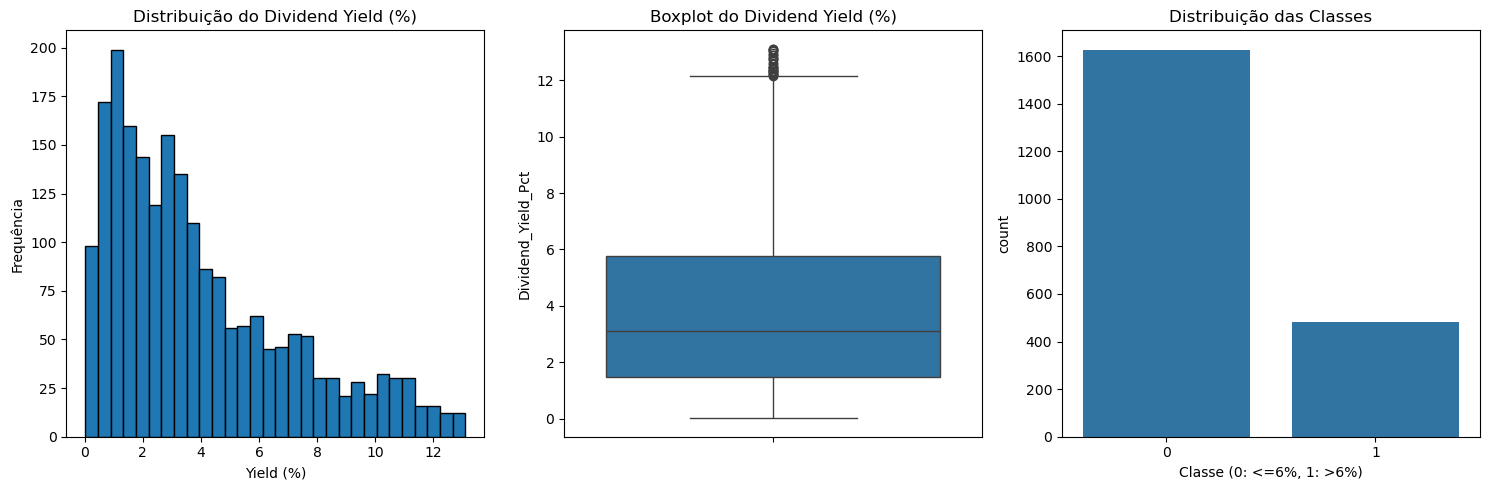


Estatísticas dos Dividend Yields:
count    2110.000000
mean        3.967005
std         3.110014
min         0.020000
25%         1.490000
50%         3.100000
75%         5.757500
max        13.110000
Name: Dividend_Yield_Pct, dtype: float64

Distribuição das classes:
target
0    0.77109
1    0.22891
Name: proportion, dtype: float64


/tmp/ipykernel_156611/2122219259.py:47: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(dividend_data_clean['target'], normalize=True))


In [9]:
# Converter yield para percentual
dividend_data['Dividend_Yield_Pct'] = dividend_data['Dividend_Yield'] * 100

# Remover outliers usando IQR
Q1 = dividend_data['Dividend_Yield'].quantile(0.25)
Q3 = dividend_data['Dividend_Yield'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dividend_data_clean = dividend_data[
    (dividend_data['Dividend_Yield'] >= lower_bound) & 
    (dividend_data['Dividend_Yield'] <= upper_bound)
]

# Criar target (0 para yield <= 6%, 1 para yield > 6%)
dividend_data_clean['target'] = np.where(dividend_data_clean['Dividend_Yield'] > 0.06, 1, 0)

# Visualização
plt.figure(figsize=(15, 5))

# Histograma de yields
plt.subplot(131)
plt.hist(dividend_data_clean['Dividend_Yield_Pct'], bins=30, edgecolor='black')
plt.title('Distribuição do Dividend Yield (%)')
plt.xlabel('Yield (%)')
plt.ylabel('Frequência')

# Boxplot
plt.subplot(132)
sns.boxplot(y=dividend_data_clean['Dividend_Yield_Pct'])
plt.title('Boxplot do Dividend Yield (%)')

# Distribuição das classes
plt.subplot(133)
sns.countplot(x='target', data=dividend_data_clean)
plt.title('Distribuição das Classes')
plt.xlabel('Classe (0: <=6%, 1: >6%)')

plt.tight_layout()
plt.show()

# Estatísticas
print("\nEstatísticas dos Dividend Yields:")
print(dividend_data_clean['Dividend_Yield_Pct'].describe())
print(f"\nDistribuição das classes:")
print(pd.value_counts(dividend_data_clean['target'], normalize=True))


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparar features
features = ['Dividend_Yield', 'Annual_Dividend_Rate', 'Market_Price']
X = dividend_data_clean[features].values
y = dividend_data_clean['target'].values

# Split dados
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Normalizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Verificar formas dos dados
print("\nForma dos dados:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")



Forma dos dados:
X_train: (1477, 3)
X_val: (316, 3)
X_test: (317, 3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3914 - auc: 0.7527 - loss: 0.7472 - val_accuracy: 0.8956 - val_auc: 1.0000 - val_loss: 0.4245
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8943 - auc: 0.9848 - loss: 0.3986 - val_accuracy: 0.9367 - val_auc: 1.0000 - val_loss: 0.2190
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9316 - auc: 0.9916 - loss: 0.1976 - val_accuracy: 0.9684 - val_auc: 1.0000 - val_loss: 0.1349
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9695 - auc: 0.9958 - loss: 0.1309 - val_accuracy: 0.9778 - val_auc: 1.0000 - val_loss: 0.0873
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9702 - auc: 0.9953 - loss: 0.1281 - val_accuracy: 0.9842 - val_auc: 1.0000 - val_loss: 0.0606
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9802 - auc: 0.9987 - loss: 0.0654 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0426
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

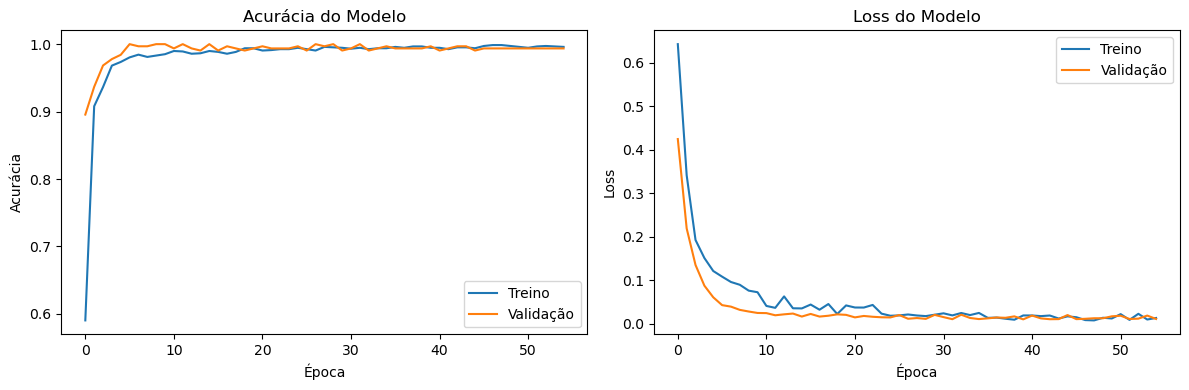


Métricas no conjunto de teste:
Acurácia: 1.0000
AUC: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


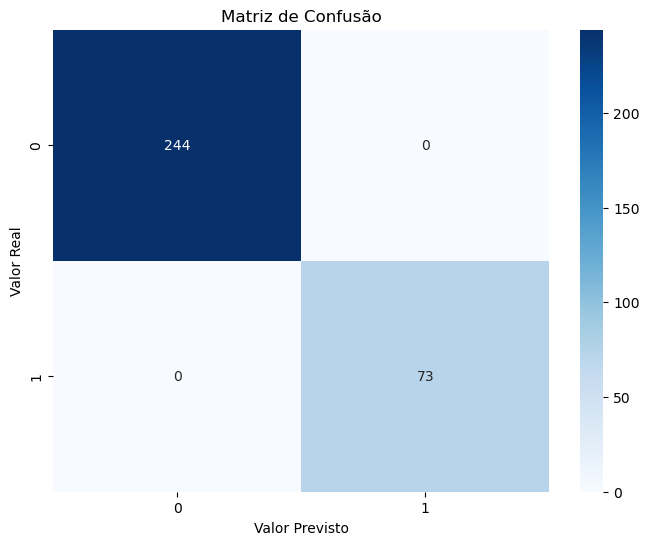


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00        73

    accuracy                           1.00       317
   macro avg       1.00      1.00      1.00       317
weighted avg       1.00      1.00      1.00       317



In [13]:
# Célula 1: Importações
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Célula 2: Criar o modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Mostrar a estrutura do modelo
model.summary()

# Célula 3: Definir callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)



# Célula 4: Treinar o modelo
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Célula 5: Plotar histórico de treinamento
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss do Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Célula 6: Avaliar no conjunto de teste
# Avaliar modelo
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nMétricas no conjunto de teste:")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")

# Fazer previsões
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Célula 7: Plotar matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

# Imprimir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
